# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [153]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure


import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os 
import random

## Load Image

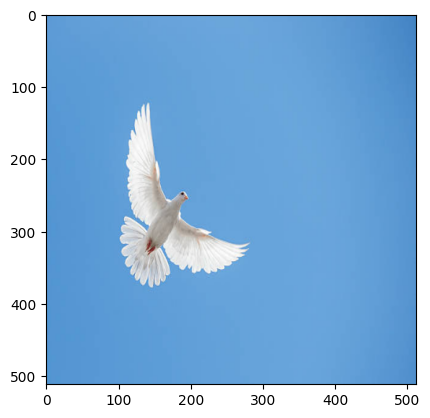

In [154]:
### START CODE HERE ###
image1 = cv2.imread("asset/Camellya.webp")
image2 = cv2.imread("asset/bird.webp")
image3 = cv2.imread("asset/bird2.jpg")
image4 = cv2.imread("asset/strawberry.jpg")
image = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512, 512))
orginal_image = image.copy()
plt.imshow(image)
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

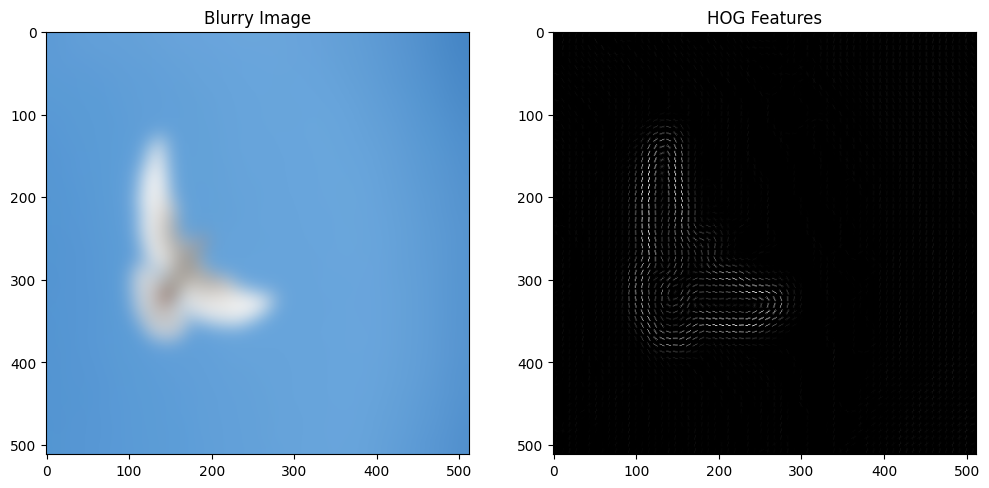

In [155]:
### START CODE HERE ###
blurry_image = cv2.GaussianBlur(image, (71, 71), 0)
fd, hog_image = hog(
    blurry_image,
    orientations=8,
    pixels_per_cell=(8, 8),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(blurry_image)
ax[0].set_title('Blurry Image')
ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title('HOG Features')
plt.show()



### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [156]:
### START CODE HERE ###
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.h, self.w, _ = image.shape
        self.hGrid = np.arange(0, self.h - tile_size[0] + 1, stride[0])
        self.wGrid = np.arange(0, self.w - tile_size[1] + 1, stride[1])
        self.hog_features = []
        self.hog_images = []
        self.extract_hog_features()

    def extract_hog_features(self):
        for h in self.hGrid:
            for w in self.wGrid:
                sub_image = self.image[h:h + self.tile_size[0], w:w + self.tile_size[1]]
                fd, hog_image = hog(
                    sub_image,
                    orientations=8,
                    pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4),
                    visualize=True,
                    channel_axis=-1
                )
                self.hog_features.append(fd)
                self.hog_images.append(hog_image)

    def plot_hog_images(self):
        fig, axes = plt.subplots(len(self.hGrid), len(self.wGrid), figsize=(15, 15))
        for i, h in enumerate(self.hGrid):
            for j, w in enumerate(self.wGrid):
                ax = axes[i, j]
                ax.imshow(self.hog_images[i * len(self.wGrid) + j], cmap='gray')
                ax.axis('off')
        plt.figure(facecolor='black')
        plt.tight_layout()
        plt.show()

    def get_num_grid(self):
        return len(self.hGrid), len(self.wGrid)
### END CODE HERE ###


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

Number of grids: (29, 29)


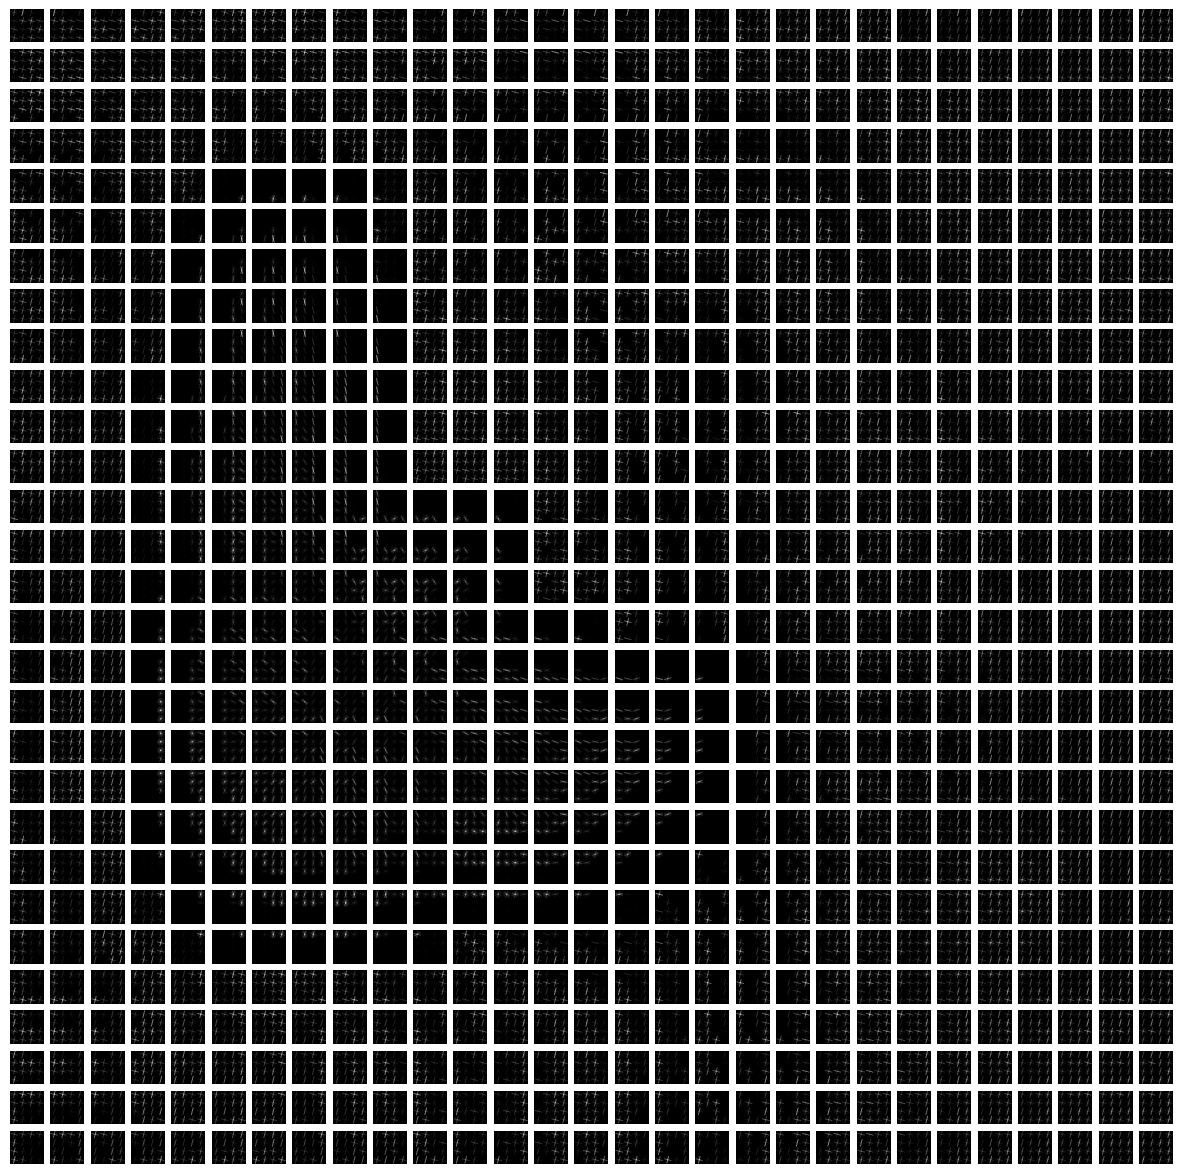

<Figure size 640x480 with 0 Axes>

In [157]:
### START CODE HERE ###
tile_size = (64, 64)
stride = (16, 16)
hog_extractor = HOGSubimageExtractor(image, tile_size, stride)
num_grid = hog_extractor.get_num_grid()
print(f'Number of grids: {num_grid}')
hog_extractor.plot_hog_images()
### END CODE HERE ###


## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [158]:
### START CODE HERE ###
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        hog_features = np.array(self.hog_extractor.hog_features)
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        kmeans.fit(hog_features)
        self.cluster_array = kmeans.labels_.reshape(self.hog_extractor.get_num_grid())
        self.all_labels = measure.label(self.cluster_array, connectivity=2)

        print("hog_features shape:", hog_features.shape)
        print("Grid shape:", self.hog_extractor.get_num_grid())
        print("cluster_array shape:", self.cluster_array.shape)
        print("Unique cluster labels:", np.unique(self.cluster_array))
        print("Unique connected component labels:", np.unique(self.all_labels))

    def plot_cluster_and_labels(self):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(self.cluster_array)
        ax[1].set_title('KMeans Cluster')
        ax[1].axis('off')
        # ax[1].imshow(self.all_labels, cmap='nipy_spectral')
        # ax[1].set_title('Connected Components')
        # ax[1].axis('off')
        plt.tight_layout()
        plt.show()

    def get_bounding_boxes(self):
        self.bounding_boxes = []
        h_num, w_num = self.hog_extractor.get_num_grid()

        tile_h = 512 // h_num
        tile_w = 512 // w_num

        for cluster_label in range(self.n_clusters):
            positions = np.argwhere(self.cluster_array == cluster_label)

            if positions.size == 0:
                continue
            min_row, min_col = positions.min(axis=0)
            max_row, max_col = positions.max(axis=0)

            top_left_y = min_row * tile_h
            top_left_x = min_col * tile_w
            bottom_right_y = (max_row + 1) * tile_h
            bottom_right_x = (max_col + 1) * tile_w

            box = {
                'cluster': cluster_label,
                'bbox': (top_left_x, top_left_y, bottom_right_x, bottom_right_y)
            }
            self.bounding_boxes.append(box)
            print(f"Cluster {cluster_label}: Bounding Box: {box['bbox']}")

        return self.bounding_boxes
### END CODE HERE ###

Complete the function below. Using [`cv2.rectangle()`](<https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html#:~:text=511%2C511)%2C(255%2C0%2C0)%2C5)-,Drawing%20Rectangle,-To%20draw%20a>)

In [159]:
### START CODE HERE ###
def draw_bbox(image, bboxes):
    img = image.copy()
    for box in bboxes:
        if isinstance(box, dict):
            x1, y1, x2, y2 = box['bbox']
            cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        else:
            x, y, w, h = box
            cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    plt.imshow(img)
    # plt.axis('off')
    plt.show()
### END CODE HERE ###


Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

hog_features shape: (841, 128)
Grid shape: (29, 29)
cluster_array shape: (29, 29)
Unique cluster labels: [0 1]
Unique connected component labels: [0 1]


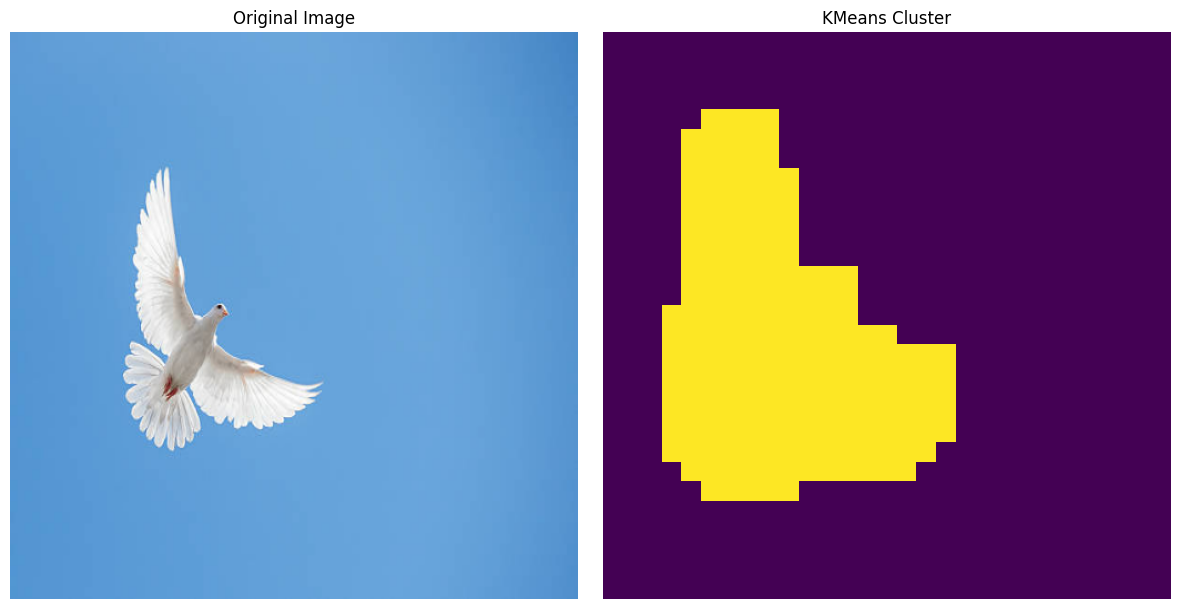

Cluster 0: Bounding Box: (np.int64(0), np.int64(0), np.int64(493), np.int64(493))
Cluster 1: Bounding Box: (np.int64(51), np.int64(68), np.int64(306), np.int64(408))


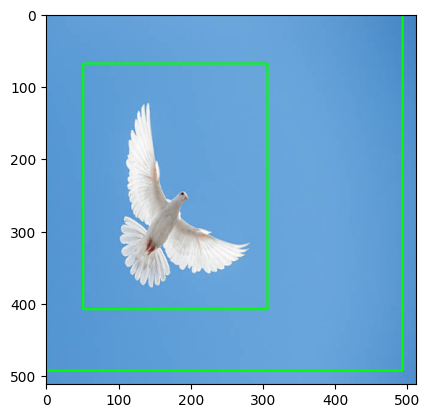

In [160]:
img = cv2.imread("asset/Camellya.webp")
img1 = cv2.imread("asset/bird2.jpg")
img2 = cv2.imread("asset/strawberry.jpg")

kmeans_cluster = KMeansCluster(hog_extractor, n_clusters=2, random_state=42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(orginal_image,bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

In [161]:
### START CODE HERE ###

tile_size = None
stride = None



### END CODE HERE ###

In [162]:
### START CODE HERE ###

tile_size = None
stride = None




### END CODE HERE ###

In [163]:
### START CODE HERE ###

tile_size = None
stride = None




### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)


1. Gaussian Blur เป็นการเบลอภาพ โดยจะลดความแตกต่างของสีพิกเซลที่อยู่ติดกัน ซึ่งการใช้ค่าพารามิเตอร์มากเกินไปจะทำให้ k-mean ไม่สามารถแยกความแตกต่างของพิกเซลใกล้เคียงได้เพราะค่าใกล้เคียงกันมากเกินไปแต่ถ้าน้อยไปจะทำให้ k-mean แยกกลุ่มได้มากเกินไป

2. pixels per cell กำหนดปริมาณของพิกเซลใน cell โดย cell ที่เล็กจะเก็บทิศทางและรายละเอียดจากภาพได้ดีมากขึ้น ทำให้สามารถแยกวัตถุต่าง ๆ ที่มีขนาดเล็กได้ชัดเจนมากขึ้น cell per block จะกำหนดปริมาณ cell ในหนึ่ง block ถ้า block มีขนาดใหญ่จะจับวัตถุขนาดใหญ่ได้ดีแต่ถ้ามากเกินไปจะทำให้เกิดการจับวัตถุได้ไม่ถูกต้อง

3. ขนาดของ tiles มีผลต่อการจับวัตถุในภาพ โดยขนาดใหญ่จะจับวัตถุขนาดใหญ่ได้ดีกว่า ถ้าขนาดเล็กก็จะแยกวัตถุขนาดเล็กออกจากกันง่ายกว่า ถ้าใช้ไม่ตรงตามขนาดของวัตถุอาจทำให้บางครั้งจะจับกลุ่มวัตถุในภาพได้ไม่ดี

4. ไม่สามารถใช้ k-means เพื่อหา anchor box ได้เพราะไม่มีข้อมูลขนาดของวัตถุให้ cluster

5. ถ้าค่า k น้อยเกินไปอาจทำให้การจับวัตถุในภาพที่ควรอยู่แยกกันมาอยู่กลุ่มเดียวกันได้ แต่ค่ามากไปทำให้การจับวัตถุคลาดเคลื่อนโดยวัตถุที่จับมาอาจจะเป็นวัตถุเดียวกันแต่ถูกจัดกลุ่มแยกกันเพราะค่า k มากเกินไป


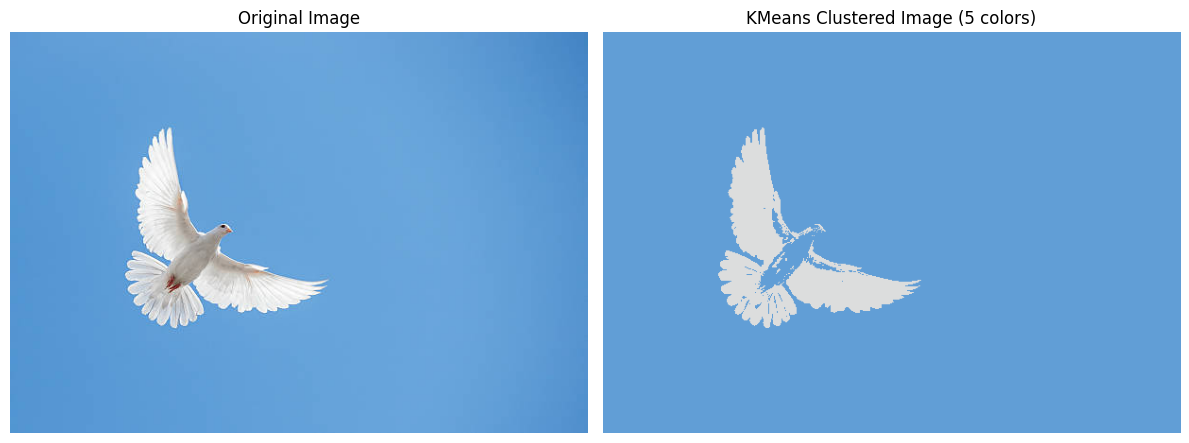

In [164]:
from sklearn.cluster import KMeans
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path = "asset/bird2.jpg"
image = Image.open(image_path).convert("RGB")
image_np = np.array(image)

# Reshape the image to a 2D array of pixels (rows: pixels, columns: RGB values)
pixels = image_np.reshape(-1, 3)

# Apply KMeans clustering with 5 clusters
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(pixels)
clustered_pixels = kmeans.cluster_centers_[kmeans.labels_].astype(np.uint8)

# Reshape back to the original image shape
clustered_image = clustered_pixels.reshape(image_np.shape)

# Show original and clustered images side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(image_np)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(clustered_image)
axs[1].set_title("KMeans Clustered Image (5 colors)")
axs[1].axis("off")

plt.tight_layout()
plt.show()
